Shape of X after cleaning: (163, 2)
Accuracy: 1.0
Precision: 1.0
Recall: 1.0

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        33

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33

Model saved to ../models/river_plastic_classifier.pkl


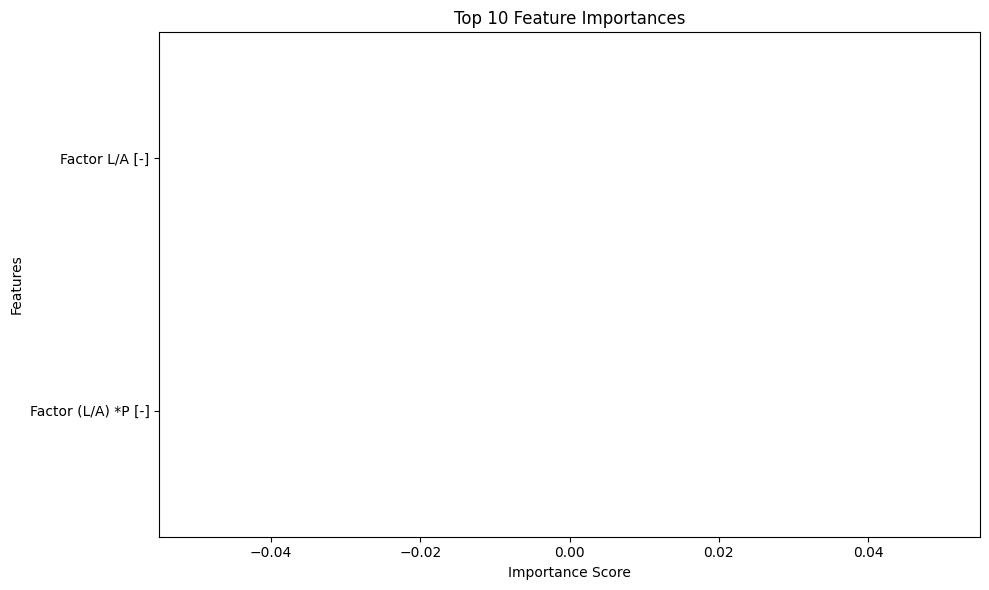

Feature importance plot saved to ../reports/feature_importance.png
Predictions saved to ../reports/test_predictions.csv


In [13]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

data_path = os.path.join("../data/global_riverine_plastic_emissions_into_ocean.csv")
df = pd.read_csv(data_path)

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

plastic_col = [col for col in df.columns if 'M[E]' in col][0]
df[plastic_col] = pd.to_numeric(df[plastic_col], errors='coerce')
df['plastic_contribution'] = df[plastic_col].apply(lambda x: 0 if x > 6008 else 1)

drop_cols = ['plastic_contribution', plastic_col]
drop_cols += [col for col in df.columns if 'Country' in col or 'Administrative' in col or 'Ratio' in col]
X = df.drop(columns=drop_cols, errors='ignore')
X = X.select_dtypes(include='number')
X = X.dropna()
y = df.loc[X.index, 'plastic_contribution']

print(f"Shape of X after cleaning: {X.shape}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

model_path = os.path.join("../models/river_plastic_classifier.pkl")
joblib.dump(model, model_path)
print(f"Model saved to {model_path}")

feature_names = X.columns
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:10], y=feat_imp.index[:10])
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()

plot_path = os.path.join("../reports/feature_importance.png")
plt.savefig(plot_path)
plt.show()
print(f"Feature importance plot saved to {plot_path}")

predictions_df = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
predictions_path = os.path.join("../reports/test_predictions.csv")
predictions_df.to_csv(predictions_path, index=False)
print(f"Predictions saved to {predictions_path}")
